In [1]:
from binance.client import Client
import config
import pandas as pd

In [2]:
exchange = Client(api_key=config.key,api_secret=config.secret,tld='us',testnet=True)

In [3]:
def getData(symbol,time,client):
    """
    1504541580000, // UTC timestamp in milliseconds, integer
    4235.4,        // (O)pen price, float
    4240.6,        // (H)ighest price, float
    4230.0,        // (L)owest price, float
    4230.7,        // (C)losing price, float
    37.72941911    // (V)olume float (usually in terms of the base currency, the exchanges docstring may list whether quote or base units are used)
    """
    klines = client.get_historical_klines(symbol=symbol, interval=time)

    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df = pd.DataFrame(klines, columns=columns)

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC')
    df['timestamp'] = df['timestamp'].dt.tz_convert('America/Chicago')
    

    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    #df.set_index('Date', inplace=True)
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(float)
    return df

In [4]:
def calculate_macd(data, **params):
    """
    Calculates the MACD line, signal line, and zero line for a given DataFrame of stock data.
    :param data: DataFrame containing stock data with at least a 'Close' column and a DatetimeIndex.
    :param EMA Long Period: The period length for the long EMA. Default is 26.
    :param EMA Short Period: The period length for the short EMA. Default is 12.
    :param Signal Line Period: The period length for the signal line. Default is 9.
    :return: DataFrame containing the MACD line, signal line, and zero line as columns, with the same index as the input DataFrame.
    """
    ema_long = data['Close'].ewm(span=params['EMA Long Period'], adjust=False).mean()
    ema_short = data['Close'].ewm(span=params['EMA Short Period'], adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=params['Signal Line Period'], adjust=False).mean()
    zero_line = pd.Series(0, index=data.index)
    macd_df = pd.concat([macd_line, signal_line, zero_line], axis=1)
    macd_df.columns = ['MACD_line', 'Signal_line', 'Zero_line']
    return macd_df


In [5]:
class MyStrategy:
    
    def generate_signals_backtest(self,data,user_input,**params):
       
        # data['Signal'] = data['Signal'].astype("float")
        if user_input == 'MACD':
            signals = self.MACD_strategy(data,**params)
        elif user_input == 'RSI':
            signals = self.RSI_strategy(data,**params)
        return signals 
    
    def RSI_strategy(self,data,**params):
        from ta.momentum import rsi
        
        # Define your trading signals here
        lower_limit= params['Buy Threshold'] 
        upper_limit = params['Sell Threshold']
        
        # Calculate the RSI indicator
        #data["RSI"] = rsi(data["Close"],window=params['RSI Period'])
        data['RSI']= ta.momentum.RSIIndicator(data["Close"], window=params['RSI Period']).rsi()
       
        #data = rsi_calculation(data,params['RSI Period'])

        #data["RSI"] = ta.momentum.RSIIndicator(close=data["close"], window=params['RSI Period']).rsi()
        data = data.dropna()
        data = data.reset_index(drop=True)
        # # Generate the signals based on the RSI value
        #data["signal"] = data['RSI'].apply(lambda x: 1 if x < lower_limit else -1 if x > upper_limit else 0)
        # Create the 'signal' column
        #data = data.copy()
        data['Signal'] = 0
        
        
        # Set a flag to track if we're currently in a position
        in_position = False
        
        # Loop through each row and set the signal based on the RSI and previous position
      
        for i in range(1, len(data)):
            rsi_value = data['RSI'][i]
           
            if in_position:
                # If we're currently in a position, continue holding until a Sell signal
                if rsi_value >= upper_limit:
                    data['Signal'][i] = -1
                    in_position = False
                else:
                    data['Signal'][i] = 0
            else:
                # If we're not currently in a position, Buy if RSI is below the lower limit
                if rsi_value <= lower_limit:
                    data['Signal'][i] = 1
                    in_position = True
                else:
                    data['Signal'][i] = 0
        return data
    def MACD_strategy(self,data,**params):
        #MACD trading strategy
        macd_df = calculate_macd(data, **params)
        data = pd.concat([data, macd_df], axis=1)
        # Set a flag to track if we're currently in a position
        in_position = False
        
        # Loop through each row and set the signal based on the RSI and previous position
        data['Signal'] = 0
        for i in range(1, len(data)):
            macd = data['MACD_line'][i]
            zero_line = data['Zero_line'][i]
            signal_line = data['Signal_line'][i]
           
            if in_position:
                # If we're currently in a position, continue holding until a Sell signal
                if (macd < signal_line) & (macd > zero_line) & (signal_line > zero_line): 
                    data['Signal'][i] = -1
                    in_position = False
                else:
                    data['Signal'][i] = 0
            else:
                # If we're not currently in a position, Buy if RSI is below the lower limit
                if (macd > signal_line) & (macd < zero_line) & (signal_line < zero_line):
                    data['Signal'][i] = 1
                    in_position = True
                else:
                    data['Signal'][i] = 0

        return data

In [6]:
 # #MACD
symbol = "ETHUSDT"
time_frame = '15m'
df = getData(symbol,time_frame,exchange) 
strategy = MyStrategy()

In [7]:
inital_parameters = {'EMA Long Period': 11.0, 'EMA Short Period': 6.0, 'Signal Line Period': 14.0}

In [8]:
signals = strategy.generate_signals_backtest(df,'MACD',**inital_parameters)
signals

C:\Users\jdlugosz\AppData\Local\Temp\ipykernel_28936\1502439823.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 0
C:\Users\jdlugosz\AppData\Local\Temp\ipykernel_28936\1502439823.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 1
C:\Users\jdlugosz\AppData\Local\Temp\ipykernel_28936\1502439823.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 0
C:\Users\jdlugosz\AppD

,Date,Open,High,Low,Close,Volume,MACD_line,Signal_line,Zero_line,Signal
0,2023-03-20 23:30:00-05:00,1750.13,1751.65,1747.54,1748.83,107.41129,0.000000,0.000000,0,0
1,2023-03-20 23:45:00-05:00,1748.60,1751.61,1746.35,1750.15,109.74199,0.157143,0.020952,0,0
2,2023-03-21 00:00:00-05:00,1750.12,1750.26,1741.36,1746.47,164.80314,-0.194898,-0.007828,0,0
3,2023-03-21 00:15:00-05:00,1746.48,1746.64,1738.30,1744.61,102.58571,-0.616594,-0.088996,0,0
4,2023-03-21 00:30:00-05:00,1744.43,1744.43,1736.85,1738.90,171.30866,-1.518003,-0.279531,0,0
...,...,...,...,...,...,...,...,...,...,...
995,2023-03-31 08:15:00-05:00,1808.78,1840.00,1807.92,1818.88,233.31657,4.646284,1.308219,0,0
996,2023-03-31 08:30:00-05:00,1819.00,1838.92,1818.77,1831.20,319.76681,6.721808,2.030030,0,0
997,2023-03-31 08:45:00-05:00,1831.44,1833.32,1824.01,1826.28,238.03215,7.051438,2.699551,0,0
998,2023-03-31 09:00:00-05:00,1826.30,1831.86,1526.04,1830.34,185.24498,7.395197,3.325637,0,0


In [9]:
# df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close','Signal'])

# # Populate the DataFrame with your data
# df['Date'] = ['2022-01-01', '2022-01-02', '2022-01-03','2022-01,04']
# df['Open'] = [100.0, 101.0, 99.0,100.0]
# df['High'] = [102.0, 103.0, 100.0,105.0]
# df['Low'] = [99.0, 99.5, 98.0,97.8]
# df['Close'] = [101.0, 102.5, 98.5,103.5]

# df['Signal'] = [1, 0, -1,0]

In [10]:
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline


In [11]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.signal = self.data.signal

    def next(self):
        if self.signal == 1:
            self.buy()
        elif self.signal == -1:
            self.sell()



In [12]:
signals.dtypes

Date           datetime64[ns, America/Chicago]
Open                                   float64
High                                   float64
Low                                    float64
Close                                  float64
Volume                                 float64
MACD_line                              float64
Signal_line                            float64
Zero_line                                int64
Signal                                   int64
dtype: object

In [13]:
# import yfinance as yf
# signals = yf.download('AAPL',start='2015-01-01')

In [14]:
signals

,Date,Open,High,Low,Close,Volume,MACD_line,Signal_line,Zero_line,Signal
0,2023-03-20 23:30:00-05:00,1750.13,1751.65,1747.54,1748.83,107.41129,0.000000,0.000000,0,0
1,2023-03-20 23:45:00-05:00,1748.60,1751.61,1746.35,1750.15,109.74199,0.157143,0.020952,0,0
2,2023-03-21 00:00:00-05:00,1750.12,1750.26,1741.36,1746.47,164.80314,-0.194898,-0.007828,0,0
3,2023-03-21 00:15:00-05:00,1746.48,1746.64,1738.30,1744.61,102.58571,-0.616594,-0.088996,0,0
4,2023-03-21 00:30:00-05:00,1744.43,1744.43,1736.85,1738.90,171.30866,-1.518003,-0.279531,0,0
...,...,...,...,...,...,...,...,...,...,...
995,2023-03-31 08:15:00-05:00,1808.78,1840.00,1807.92,1818.88,233.31657,4.646284,1.308219,0,0
996,2023-03-31 08:30:00-05:00,1819.00,1838.92,1818.77,1831.20,319.76681,6.721808,2.030030,0,0
997,2023-03-31 08:45:00-05:00,1831.44,1833.32,1824.01,1826.28,238.03215,7.051438,2.699551,0,0
998,2023-03-31 09:00:00-05:00,1826.30,1831.86,1526.04,1830.34,185.24498,7.395197,3.325637,0,0


In [15]:
class MyPandasData(bt.feeds.PandasData):
    lines = ('signal',)  # specify the 'signal' column as a LineSeries

    params = (
        ('datetime', 'Date'),  # specify the name of the datetime column
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', None),
        ('signal', -1),  # specify the index of the 'signal' column
    )


In [16]:

cerebro = bt.Cerebro()
#data = bt.feeds.PandasData(dataname=signals)
data = MyPandasData(dataname=signals)
cerebro.adddata(data)
cerebro.addstrategy(MyStrategy)
# Add analyzers to cerebro
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
results = cerebro.run()

In [17]:
cerebro.plot()
plt.show()



<IPython.core.display.Javascript object>

In [18]:
fig = cerebro.plot()[0][0]
fig.savefig("myplot1.png")

<IPython.core.display.Javascript object>

In [19]:
# Get performance metrics
sharpe_ratio = results[0].analyzers.sharpe_ratio.get_analysis()
transactions = results[0].analyzers.transactions.get_analysis()
trade_analyzer = results[0].analyzers.trade_analyzer.get_analysis()
sharpe_ratio
# print(f"Sharpe ratio: {sharpe_ratio['sharperatio']:.2f}")
# print(f"Total trades: {transactions['total']}")
# print(f"Win rate: {trade_analyzer['won']['total'] / trade_analyzer['total']['total']:.2f}")

OrderedDict([('sharperatio', None)])

In [20]:
from backtesting import Strategy
from backtesting.lib import crossover

class MACDStrategy(Strategy):
    
    def init(self):
        # Set the MACD parameters
        self.macd_fast = 12
        self.macd_slow = 26
        self.macd_signal = 9
        
        # Add the MACD indicator to the strategy
        self.macd = self.I(talib.MACD, self.data.Close, self.macd_fast, self.macd_slow, self.macd_signal)
        
    def next(self):
        if crossover(self.macd.macd, self.macd.signal):
            self.buy()
        elif crossover(self.macd.signal, self.macd.macd):
            self.sell()


c:\Users\jdlugosz\AppData\Local\Programs\Python\Python38-32\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import itertools
from tqdm import tqdm
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
class Backtester:
    def __init__(self, data, strategy, selected_strategy, initial_account_value, investment_amount, fee_per_trade):
        self.data = data
        self.strategy = strategy
        self.selected_strategy = selected_strategy
        self.initial_account_value = initial_account_value
        self.investment_amount = investment_amount
        self.fee_per_trade = fee_per_trade


    def run_backtest(self, **kwargs):
        params = kwargs
        # Create a copy of the data to avoid modifying the original
        data = self.data.copy()
        
        # Apply the strategy to the data
        signals = self.strategy.generate_signals_backtest(data, self.selected_strategy, **params)

        # Set up variables to track portfolio performance
        num_trades = 0
        num_winning_trades = 0
        num_losing_trades = 0
        total_profit = 0
        total_fees = 0
        
        # Iterate through each row in the data and execute trades based on signals
        for i in range(len(data)):
            # Get the current signal
            signal = signals.iloc[i]['Signal']

            # If the signal is 1 (buy), execute a buy trade
            if signal == 1:
                # Calculate the amount to invest
                investment = min(self.investment_amount, self.initial_account_value)
                # Calculate the number of shares to buy
                num_shares = investment / data.iloc[i]['Close']
                # Calculate the total cost of the trade (including fees)
                cost = investment + self.fee_per_trade
                # Update the account value
                self.initial_account_value -= cost
                # Increment the number of trades
                num_trades += 1
                
            # If the signal is -1 (sell), execute a sell trade
            elif signal == -1:
                # Calculate the number of shares to sell
                num_shares = self.investment_amount / data.iloc[i]['Close']
                # Calculate the total proceeds of the trade (excluding fees)
                proceeds = num_shares * data.iloc[i]['Close']
                # Calculate the total value of the trade (including fees)
                value = proceeds - self.fee_per_trade
                # Update the account value
                self.initial_account_value += value
                # Calculate the profit of the trade
                profit = value - self.investment_amount
                # Update the total profit
                total_profit += profit
                # Update the number of trades and winning/losing trades
                num_trades += 1
                if profit > 0:
                    num_winning_trades += 1
                else:
                    num_losing_trades += 1
                # Reset the investment amount
                self.investment_amount = 0

        # Calculate the winrate
        if num_trades > 0:
            winrate = num_winning_trades / num_trades
        else:
            winrate = 0
        
        results = {
        "initial_account_value": self.initial_account_value,
        "total_profit": total_profit,
        "total_fees": total_fees,
        "num_trades": num_trades,
        "num_winning_trades": num_winning_trades,
        "num_losing_trades": num_losing_trades,
        "winrate": winrate
        }

        # Return the results dictionary
        return results
    
    def optimize_parameters(self, parameter_values):
        best_params = None
        best_performance = None
        
        for params in tqdm(parameter_values):
            performance = self.run_backtest(**params)
            try:                                                    
                if best_performance is None or performance['total_returns'] > best_performance['total_returns']:
                    best_params = params
                    best_performance = performance
            except:
                continue

        return best_params, best_performance

In [22]:
exchange = Client(api_key=config.key,api_secret=config.secret,tld='us',testnet=True)
# #MACD
symbol = "LINKUSD"
time_frame = '15m'
df = getData(symbol,time_frame,exchange) 
strategy = MyStrategy()
backtester = Backtester(df, strategy,'MACD',5000, 1000, 0.0099)

inital_parameters = {'EMA Long Period': 22.0, 'EMA Short Period': 12.0, 'Signal Line Period': 10.0}
    
print(backtester.run_backtest(**inital_parameters))

BinanceAPIException: APIError(code=-1121): Invalid symbol.

In [ ]:
def generate_parameter_combinations(param_names, param_ranges):
    param_combinations = itertools.product(*param_ranges)
    parameter_values = [{param_names[i]: p[i] for i in range(len(param_names))} for p in param_combinations]
    return parameter_values

In [ ]:
param_name = ["EMA Long Period", "EMA Short Period", "Signal Line Period"]
param_value = [{x for x in range(10, 30, 1)},{x for x in range(1, 15, 1)},{x for x in range(1, 14, 1)}]
param_combo = generate_parameter_combinations(param_name, param_value)
best_params, best_performance = backtester.optimize_parameters(param_combo)

print("Best parameters:", best_params)
print("Best performance:", best_performance)

100%|██████████| 3640/3640 [06:34<00:00,  9.22it/s]

Best parameters: {'EMA Long Period': 10, 'EMA Short Period': 1, 'Signal Line Period': 1}
Best performance: {'initial_account_value': 4999.7921, 'total_profit': 0, 'total_fees': 0, 'num_trades': 0, 'num_winning_trades': 0, 'num_losing_trades': 0, 'winrate': 0}


In [ ]:
symbol = "ETHUSDT"
time_frame = '15m'
data = getData(symbol,time_frame,exchange) 
# Calculate the price supports and resistances
import plotly.graph_objs as go
import pandas as pd

# Create trace for the candlestick chart
trace = go.Candlestick(
    x=data['Date'],
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close']
)

# Create layout for the plot
layout = go.Layout(
    title='Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price')
)

# Create the plot figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()


In [ ]:
data.tail()

,Date,Open,High,Low,Close,Volume
995,2023-03-29 19:30:00-05:00,1796.02,1802.66,1793.66,1794.55,103.77482
996,2023-03-29 19:45:00-05:00,1794.01,1794.01,1776.88,1785.99,224.98847
997,2023-03-29 20:00:00-05:00,1785.59,1789.31,1781.72,1784.95,239.59834
998,2023-03-29 20:15:00-05:00,1785.08,1803.99,1783.55,1791.75,199.15309
999,2023-03-29 20:30:00-05:00,1791.56,1791.56,1789.44,1791.15,15.30505


In [ ]:
data

,Date,Open,High,Low,Close,Volume
0,2023-03-19 10:45:00-05:00,1790.31,1804.59,1786.64,1794.91,277.35589
1,2023-03-19 11:00:00-05:00,1794.57,1800.71,1765.60,1796.47,323.08669
2,2023-03-19 11:15:00-05:00,1796.31,1805.16,1795.80,1799.86,259.70053
3,2023-03-19 11:30:00-05:00,1799.86,1830.00,1798.20,1820.74,376.29933
4,2023-03-19 11:45:00-05:00,1820.86,1834.40,1810.00,1816.03,334.06327
...,...,...,...,...,...,...
995,2023-03-29 19:30:00-05:00,1796.02,1802.66,1793.66,1794.55,103.77482
996,2023-03-29 19:45:00-05:00,1794.01,1794.01,1776.88,1785.99,224.98847
997,2023-03-29 20:00:00-05:00,1785.59,1789.31,1781.72,1784.95,239.59834
998,2023-03-29 20:15:00-05:00,1785.08,1803.99,1783.55,1791.75,199.15309


In [ ]:
import ccxt
import pandas as pd

# Initialize the Binance exchange object
binance = ccxt.binanceus()

# Define the symbol and timeframe for the data
symbol = 'LINK/USDT'
timeframe = '15m'

# Fetch historical OHLCV data
ohlcv = binance.fetch_ohlcv(symbol, timeframe)

# Convert the data to a Pandas DataFrame and clean up the column names
df = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
#df.set_index('Timestamp', inplace=True)

# Print the last few rows of the DataFrame
print(df.tail())

              Timestamp  Open  High   Low  Close  Volume
495 2023-03-30 18:15:00  7.18  7.18  7.18   7.18    0.74
496 2023-03-30 18:30:00  7.18  7.18  7.18   7.18    0.00
497 2023-03-30 18:45:00  7.18  7.18  7.18   7.18    0.00
498 2023-03-30 19:00:00  7.18  7.18  7.18   7.18    0.00
499 2023-03-30 19:15:00  7.18  7.18  7.18   7.18    0.00


In [ ]:
df

,Date,Open,High,Low,Close,Volume
0,2023-03-20 11:00:00-05:00,1762.96,1768.87,1756.01,1758.70,301.31269
1,2023-03-20 11:15:00-05:00,1758.83,1770.00,1730.00,1760.22,359.44008
2,2023-03-20 11:30:00-05:00,1759.53,1764.41,1755.00,1758.98,297.89347
3,2023-03-20 11:45:00-05:00,1758.32,1770.00,1247.17,1753.39,299.69642
4,2023-03-20 12:00:00-05:00,1752.97,1761.37,1247.17,1759.31,302.30833
...,...,...,...,...,...,...
995,2023-03-30 19:45:00-05:00,1800.93,1808.51,1799.70,1807.01,149.61603
996,2023-03-30 20:00:00-05:00,1806.93,1817.42,1805.40,1812.48,245.14034
997,2023-03-30 20:15:00-05:00,1812.17,1814.23,1810.65,1811.11,142.62686
998,2023-03-30 20:30:00-05:00,1810.20,1811.42,1802.12,1803.81,141.53882


In [ ]:
import pandas as pd

def fibonacci_retracement(df):
    """
    Calculates Fibonacci retracement levels based on the most recent upward or downward trend in a DataFrame.

    Args:
        df (pandas.DataFrame): Input DataFrame with columns "Open", "High", "Low", and "Close".

    Returns:
        pandas.DataFrame: New DataFrame with additional columns for Fibonacci retracement levels.

    """

    # Create new DataFrame with the same columns as input
    df_fib = df.copy()

    # Calculate the high and low of the most recent trend
    last_trend_high = df_fib.iloc[0]['High']
    last_trend_low = df_fib.iloc[0]['Low']
    last_trend_up = True

    # Loop through each row in the DataFrame and calculate Fibonacci levels
    for i, row in df_fib.iterrows():

        # If the current high is higher than the last trend high, we are in an upward trend
        if row['High'] > last_trend_high:
            last_trend_high = row['High']
            last_trend_low = row['Low']
            last_trend_up = True

        # If the current low is lower than the last trend low, we are in a downward trend
        elif row['Low'] < last_trend_low:
            last_trend_low = row['Low']
            last_trend_high = row['High']
            last_trend_up = False

        # Calculate the retracement levels based on the most recent trend
        if last_trend_up:
            diff = last_trend_high - last_trend_low
            df_fib.at[i, '38.2%'] = last_trend_high - (0.382 * diff)
            df_fib.at[i, '50.0%'] = last_trend_high - (0.5 * diff)
            df_fib.at[i, '61.8%'] = last_trend_high - (0.618 * diff)
        else:
            diff = last_trend_high - last_trend_low
            df_fib.at[i, '38.2%'] = last_trend_low + (0.382 * diff)
            df_fib.at[i, '50.0%'] = last_trend_low + (0.5 * diff)
            df_fib.at[i, '61.8%'] = last_trend_low + (0.618 * diff)

    # Return the new DataFrame with Fibonacci retracement levels
    return df_fib


In [ ]:


# Calculate Fibonacci retracement levels
df_fib = fibonacci_retracement(df)

# Print the new DataFrame
print(df_fib)


                         Date     Open     High      Low    Close     Volume  \
0   2023-03-20 11:00:00-05:00  1762.96  1768.87  1756.01  1758.70  301.31269   
1   2023-03-20 11:15:00-05:00  1758.83  1770.00  1730.00  1760.22  359.44008   
2   2023-03-20 11:30:00-05:00  1759.53  1764.41  1755.00  1758.98  297.89347   
3   2023-03-20 11:45:00-05:00  1758.32  1770.00  1247.17  1753.39  299.69642   
4   2023-03-20 12:00:00-05:00  1752.97  1761.37  1247.17  1759.31  302.30833   
..                        ...      ...      ...      ...      ...        ...   
995 2023-03-30 19:45:00-05:00  1800.93  1808.51  1799.70  1807.01  149.61603   
996 2023-03-30 20:00:00-05:00  1806.93  1817.42  1805.40  1812.48  245.14034   
997 2023-03-30 20:15:00-05:00  1812.17  1814.23  1810.65  1811.11  142.62686   
998 2023-03-30 20:30:00-05:00  1810.20  1811.42  1802.12  1803.81  141.53882   
999 2023-03-30 20:45:00-05:00  1803.72  1803.98  1801.44  1802.24   69.06201   

          38.2%     50.0%       61.8%  

In [ ]:
def stochastic_oscillator(df, params):
    """
    Calculates the Stochastic Oscillator indicator for a DataFrame.

    Args:
        df (pandas.DataFrame): Input DataFrame with columns "Open", "High", "Low", and "Close".
        params (dict): Dictionary containing the parameter names and values.

    Returns:
        pandas.DataFrame: New DataFrame with additional columns for the %K and %D lines of the Stochastic Oscillator.

    """

    # Create new DataFrame with the same columns as input
    df_so = df.copy()

    # Extract the parameters from the dictionary
    k_period = params['k_period']
    d_period = params['d_period']

    # Calculate the highest high and lowest low over the past k_period periods
    df_so['HH'] = df_so['High'].rolling(k_period).max()
    df_so['LL'] = df_so['Low'].rolling(k_period).min()

    # Calculate the %K line
    df_so['K'] = 100 * ((df_so['Close'] - df_so['LL']) / (df_so['HH'] - df_so['LL']))

    # Calculate the %D line
    df_so['D'] = df_so['K'].rolling(d_period).mean()
    df_so = df_so.dropna()
    df_so = df_so.reset_index()
    # Return the new DataFrame with %K and %D columns
    return df_so






In [ ]:
# Define the parameters as a dictionary
params = {'k_period': 14, 'd_period': 3}

# Calculate Stochastic Oscillator indicator
df = stochastic_oscillator(df, params)

# Print the new DataFrame
print(df)

     index                      Date     Open     High      Low    Close  \
0       30 2023-03-20 18:30:00-05:00  1732.27  1736.52  1718.10  1724.16   
1       31 2023-03-20 18:45:00-05:00  1723.99  1733.10  1722.00  1732.69   
2       32 2023-03-20 19:00:00-05:00  1732.72  1734.60  1718.10  1734.28   
3       33 2023-03-20 19:15:00-05:00  1734.27  1750.00  1732.34  1741.60   
4       34 2023-03-20 19:30:00-05:00  1741.66  1770.00  1000.00  1747.95   
..     ...                       ...      ...      ...      ...      ...   
965    995 2023-03-30 19:45:00-05:00  1800.93  1808.51  1799.70  1807.01   
966    996 2023-03-30 20:00:00-05:00  1806.93  1817.42  1805.40  1812.48   
967    997 2023-03-30 20:15:00-05:00  1812.17  1814.23  1810.65  1811.11   
968    998 2023-03-30 20:30:00-05:00  1810.20  1811.42  1802.12  1803.81   
969    999 2023-03-30 20:45:00-05:00  1803.72  1803.98  1801.44  1802.24   

        Volume       HH       LL          K          D  Crossover  
0    273.75928  177

In [ ]:
def crossover(df, s1, s2):
    """
    Calculates the crossover signals between two time-series data.

    Args:
        df (pandas.DataFrame): DataFrame containing the input data.
        s1 (pandas.Series): First time-series data.
        s2 (pandas.Series): Second time-series data.

    Returns:
        pandas.DataFrame: DataFrame with an additional column 'Crossover' with values of 1, 0, -1 indicating the occurrence of a bullish, no crossover, or bearish signal, respectively.

    """
    # Create a new column for crossover signals
    
    df['Crossover'] = 0

    # Loop through the data
    for i in range(1, len(df)):
        if s1[i] > s2[i] and s1[i - 1] <= s2[i - 1]:
            # Bullish crossover signal
            df.loc[i, 'Crossover'] = 1
        elif s1[i] < s2[i] and s1[i - 1] >= s2[i - 1]:
            # Bearish crossover signal
            df.loc[i, 'Crossover'] = -1

    return df


In [ ]:

# Calculate the crossover signals
crossover_signals = crossover(df,df['K'], df['D'])

# Print the crossover signals
print(crossover_signals)

     index                      Date     Open     High      Low    Close  \
0       30 2023-03-20 18:30:00-05:00  1732.27  1736.52  1718.10  1724.16   
1       31 2023-03-20 18:45:00-05:00  1723.99  1733.10  1722.00  1732.69   
2       32 2023-03-20 19:00:00-05:00  1732.72  1734.60  1718.10  1734.28   
3       33 2023-03-20 19:15:00-05:00  1734.27  1750.00  1732.34  1741.60   
4       34 2023-03-20 19:30:00-05:00  1741.66  1770.00  1000.00  1747.95   
..     ...                       ...      ...      ...      ...      ...   
965    995 2023-03-30 19:45:00-05:00  1800.93  1808.51  1799.70  1807.01   
966    996 2023-03-30 20:00:00-05:00  1806.93  1817.42  1805.40  1812.48   
967    997 2023-03-30 20:15:00-05:00  1812.17  1814.23  1810.65  1811.11   
968    998 2023-03-30 20:30:00-05:00  1810.20  1811.42  1802.12  1803.81   
969    999 2023-03-30 20:45:00-05:00  1803.72  1803.98  1801.44  1802.24   

        Volume       HH       LL          K          D  Crossover  
0    273.75928  177

In [3]:
import ccxt
import pandas as pd

# Initialize the Binance exchange object
binance = ccxt.binanceus()

# Define the symbol and timeframe for the data
symbol = 'LINK/USDT'
timeframe = '15m'

# Fetch historical OHLCV data
ohlcv = binance.fetch_ohlcv(symbol, timeframe)

# Convert the data to a Pandas DataFrame and clean up the column names
df = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
#df.set_index('Timestamp', inplace=True)

# Print the last few rows of the DataFrame
print(df)

                   Date   Open   High    Low  Close   Volume
0   2023-03-29 16:15:00  7.334  7.335  7.319  7.335   243.24
1   2023-03-29 16:30:00  7.315  7.315  7.302  7.302    13.61
2   2023-03-29 16:45:00  7.298  7.298  7.285  7.285    17.47
3   2023-03-29 17:00:00  7.303  7.303  7.302  7.302     6.99
4   2023-03-29 17:15:00  7.340  7.359  7.335  7.335  1042.85
..                  ...    ...    ...    ...    ...      ...
495 2023-04-03 20:00:00  7.351  7.351  7.158  7.172  1406.39
496 2023-04-03 20:15:00  7.177  7.200  7.135  7.135   938.76
497 2023-04-03 20:30:00  7.186  7.186  7.113  7.165   219.12
498 2023-04-03 20:45:00  7.136  7.136  7.093  7.093    91.07
499 2023-04-03 21:00:00  7.095  7.095  7.071  7.071    27.35

[500 rows x 6 columns]


In [37]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load price data
data = df

# Calculate the percentage change in prices
data['change'] = data['Close'].pct_change()

# Define the threshold for a significant price movement
threshold = 0.006

# Create a new column to store the Zig Zag indicator
data['zigzag'] = np.nan

# Initialize variables to track the current trend and the last significant price movement
trend = 0
last_significant_move = 0

# Loop through the data and calculate the Zig Zag indicator
for i in range(1, len(data)):
    if data['change'][i] > threshold:
        # If the price has increased significantly, mark the current price as a peak
        trend = 1
        last_significant_move = i
        data['zigzag'][i] = data['Close'][i]
    elif data['change'][i] < -threshold:
        # If the price has decreased significantly, mark the current price as a valley
        trend = -1
        last_significant_move = i
        data['zigzag'][i] = data['Close'][i]
    else:
        # If the price has not moved significantly, continue the current trend
        data['zigzag'][i] = data['zigzag'][i-1] if trend == 1 else data['zigzag'][last_significant_move]

# Plot the Zig Zag indicator using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['Close'], name='Price'))
fig.add_trace(go.Scatter(x=data['Date'], y=data['zigzag'], name='Zig Zag'))
fig.update_layout(title='Zig Zag Indicator', xaxis_title='Date', yaxis_title='Price')
fig.show()


In [66]:
def calculate_atr(high, low, close, period):
    tr = np.maximum(
        np.maximum(high - low, np.abs(high - np.roll(close, 1))),
        np.abs(low - np.roll(close, 1))
    )
    atr = np.zeros(len(close))
    atr[period-1] = np.mean(tr[:period])
    for i in range(period, len(close)):
        atr[i] = ((period - 1) * atr[i-1] + tr[i]) / period
    atr = atr[period-1:]
    return atr.tolist()


In [53]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import pearsonr

def linear_regression_channel(df, std_deviation, look_back):
    """
    This function returns a dataframe with prices corresponding to the Upper Deviation,
    Slope, Lower Deviation, and Correlation columns of the Linear Regression Channel.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data to be used to calculate the linear regression channel.
        
    std_deviation : int
        The number of standard deviations to be used for calculating the channel.
        
    look_back : int
        The number of data points to be used for calculating the linear regression slope.
        
    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the prices corresponding to the Upper Deviation, Slope,
        Lower Deviation, and Correlation columns of the Linear Regression Channel.
    """
    # Calculate the linear regression slope
    df['Slope'] = df['Close'].rolling(window=look_back).apply(lambda x: stats.linregress(range(len(x)), x)[0])
    
    # Calculate the linear regression intercept
    df['Intercept'] = df['Close'].rolling(window=look_back).apply(lambda x: stats.linregress(range(len(x)), x)[1])
    
    # Calculate the linear regression channel
    df['Upper_Deviation'] = df['Intercept'] + std_deviation * df['Close'].rolling(window=look_back).std()
    df['Lower_Deviation'] = df['Intercept'] - std_deviation * df['Close'].rolling(window=look_back).std()
    
    # Calculate the correlation coefficient
    df['Correlation'] = df['Close'].rolling(window=look_back).corr(df['Slope'])
    
    return df



In [54]:
linear_regression_channel(df,2,100)

,Date,Open,High,Low,Close,Volume,Slope,Intercept,Upper_Deviation,Lower_Deviation,Correlation
0,2023-03-29 15:45:00,7.366,7.372,7.360,7.360,55.69,NaN,NaN,NaN,NaN,NaN
1,2023-03-29 16:00:00,7.354,7.354,7.354,7.354,0.26,NaN,NaN,NaN,NaN,NaN
2,2023-03-29 16:15:00,7.334,7.335,7.319,7.335,243.24,NaN,NaN,NaN,NaN,NaN
3,2023-03-29 16:30:00,7.315,7.315,7.302,7.302,13.61,NaN,NaN,NaN,NaN,NaN
4,2023-03-29 16:45:00,7.298,7.298,7.285,7.285,17.47,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,2023-04-03 19:30:00,7.392,7.392,7.392,7.392,0.00,0.001134,7.200362,7.345285,7.055438,0.603893
496,2023-04-03 19:45:00,7.382,7.382,7.354,7.369,59.99,0.001225,7.196598,7.343053,7.050143,0.615938
497,2023-04-03 20:00:00,7.351,7.351,7.158,7.172,1406.39,0.001195,7.196901,7.344178,7.049623,0.575780
498,2023-04-03 20:15:00,7.177,7.200,7.135,7.135,938.76,0.001152,7.197330,7.346253,7.048408,0.526728


In [65]:
def linear_regression_channel(df, std_deviation, look_back):
    """
    This function returns a dataframe with prices corresponding to the Upper Deviation,
    Slope, Lower Deviation, and Correlation columns of the Linear Regression Channel.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data to be used to calculate the linear regression channel.
        
    std_deviation : int
        The number of standard deviations to be used for calculating the channel.
        
    look_back : int
        The number of data points to be used for calculating the linear regression slope.
        
    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the prices corresponding to the Upper Deviation, Slope,
        Lower Deviation, and Correlation columns of the Linear Regression Channel.
    """
    # Calculate the linear regression slope
    df['Slope'] = df['Close'].rolling(window=look_back,min_periods=1).apply(lambda x: stats.linregress(range(len(x)), x)[0])
    
    # Calculate the linear regression intercept
    df['Intercept'] = df['Close'].rolling(window=look_back,min_periods=1).apply(lambda x: stats.linregress(range(len(x)), x)[1])
    
    # Calculate the linear regression channel
    df['Upper_Deviation'] = df['Intercept'] + std_deviation * df['Close'].rolling(window = look_back,min_periods=1).std()
    df['Lower_Deviation'] = df['Intercept'] - std_deviation * df['Close'].rolling(window = look_back,min_periods=1).std()
    
    # Calculate the correlation coefficient
    df['Correlation'] = df['Close'].rolling(window=look_back,min_periods=1).corr(df['Slope'])
    
    return df


In [68]:
linear_regression_channel(df, 2, 100).to_csv('data.csv')

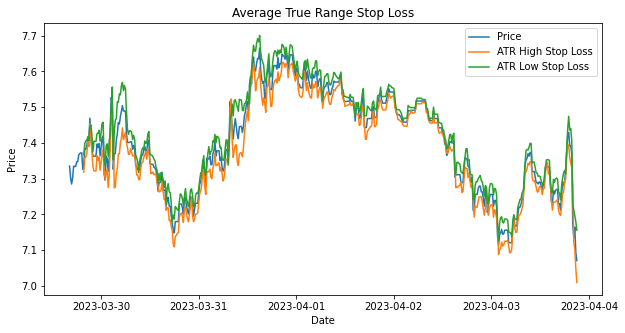

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define function to calculate ATR
def calculate_atr_stoploss(df, length=14):
    df['TR'] = np.max([df['High'] - df['Low'], abs(df['High'] - df['Close'].shift()), abs(df['Low'] - df['Close'].shift())], axis=0)
    df['ATR'] = df['TR'].rolling(window=length).mean()
    # Set inputs for stop loss calculation
    multiplier = 1.5
    src1 = 'High'
    src2 = 'Low'

    # Calculate stop loss levels
    df['ATR_High'] = df[src1] - multiplier * df['ATR']
    df['ATR_Low'] = df[src2] + multiplier * df['ATR']
    return df

# Load sample data
#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')
#print(df)
# Calculate ATR with default parameters
df = calculate_atr(df)

# Set inputs for stop loss calculation
multiplier = 1.5
src1 = 'High'
src2 = 'Low'

# Calculate stop loss levels
df['ATR_High'] = df[src1] - multiplier * df['ATR']
df['ATR_Low'] = df[src2] + multiplier * df['ATR']

# Plot stop loss levels
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df['Date'], df['Close'], label='Price')
ax.plot(df['Date'], df['ATR_High'], label='ATR High Stop Loss')
ax.plot(df['Date'], df['ATR_Low'], label='ATR Low Stop Loss')
ax.legend()
ax.set_title('Average True Range Stop Loss')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()

# Print ATR and stop loss levels for last date
last_date = df
